In [1]:
# Importing necessary libraries
import os
import math
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU, Dropout, Lambda, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, Nadam
from keras import regularizers, backend as K, utils
from keras.regularizers import Regularizer
from keras.utils import register_keras_serializable
from google.colab import drive
from datetime import datetime

# fixing random seed for reproducibility
seed = 2022
np.random.seed(seed)

In [2]:
# Mounting Google Drive to access files
drive.mount('/content/gdrive')
Increasing_BW_data = pd.read_fwf('/content/gdrive/My Drive/Data/Increasing_BW.txt')

Mounted at /content/gdrive


# Steps below are performing some data_preprocessing

In [3]:
datasets = [Increasing_BW_data]

In [4]:
# Defining a function to apply the operation for removing strings from the data
def extract_and_convert_to_float(df):
    for column in df.columns:
      if pd.api.types.is_string_dtype(df[column]):
        df[column] = df[column].str.extract(r'(\d+[.\d]*)').astype(float)
    return df

for df in datasets:
    df = extract_and_convert_to_float(df)

In [5]:
# Dropping off irrelevant columns and only keeping the relevant
data_frames = [Increasing_BW_data]
for df in data_frames:
   df.drop(columns=df.columns.difference(['Transfer', 'Bandwidth']), inplace=True)

In [6]:
df['increment'] = range(len(Increasing_BW_data))

In [7]:
# Dividing 'Transfer' column values by 1024 for data conversion to MBytes
Increasing_BW_data.loc[0:38, 'Transfer'] /= 1024

In [8]:
# Multiplying 'Bandwidth' column values by 1000 where the value is less than 5 to make uniformity of MBytes/Sec
Increasing_BW_data.loc[Increasing_BW_data['Bandwidth'] < 5, 'Bandwidth'] *= 1000

In [9]:
# Dropping off outlier points
Increasing_BW_data.drop([1159, 3980], inplace=True)

# Visualizing the data we shall make predictions on

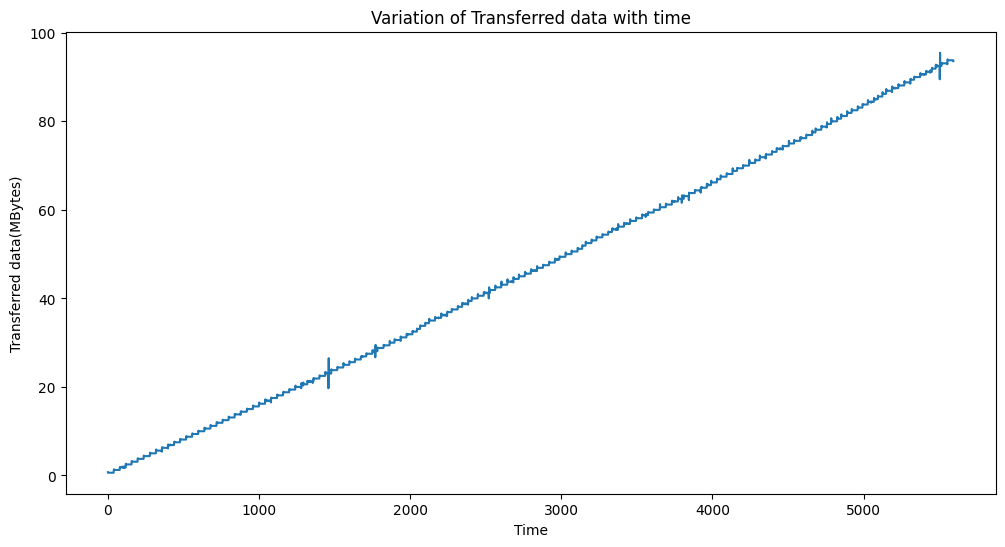

In [10]:
import seaborn as sns
# Creating a plot to visualize the data
plt.figure(figsize=(12, 6))
sns.lineplot(x='increment', y='Transfer', data=Increasing_BW_data)
plt.xlabel('Time')
plt.ylabel('Transferred data(MBytes)')
plt.title('Variation of Transferred data with time')
plt.show()

In [11]:
# Checking the shape of the Data'
Increasing_BW_data.shape

(5593, 3)

# Perfoming data splitting (Training_set, Validation_set, Test_set)

In [12]:
# Defining train_size as 70% of the length of the data
train_size = int(0.7 * len(Increasing_BW_data))
# Creating the train_set by selecting the first 70% of the data
train_set = Increasing_BW_data[:train_size]

In [13]:
# Defining validation_size as 15% of the length of the data
val_size = int(0.15 * len(Increasing_BW_data))
# Creating the val_set by selecting the first 15% of the data
val_set = Increasing_BW_data[train_size:train_size + val_size]

In [14]:
# Creating the test_set by selecting the data after the train_set and val_set
test_set = Increasing_BW_data[train_size + val_size:]

In [15]:
# Concatenating train_set and val_set to create train_all_data
train_all = pd.concat([train_set, val_set], axis=0)

In [16]:
# Extracting data from dataframes, selecting the features
# The labels simply contain the Transferred Trafic

#  Selecting which features to use:

def feature_matrix(df,features):
    numsamples = df.shape[0]
    numfeatures = len(features)

    fm = np.zeros((numsamples,numfeatures))
    for idx in range(numfeatures):
        fm[:,idx] = df[features[idx]]
    return fm

features = ['Bandwidth', 'Transfer']

# Important: Tensorflow 2.x gives an error omitting
# the np.asarray(...,,dtype=np.float32)

# trainining  and validation data
train_values = np.asarray(feature_matrix(train_set,features),dtype=np.float32)
train_labels = np.asarray(train_set['Transfer'],dtype=np.float32)

val_values = np.asarray(feature_matrix(val_set,features),dtype=np.float32)
val_labels = np.asarray(val_set['Transfer'],dtype=np.float32)

# train_all_data for retraining before testing
train_all_values = np.asarray(feature_matrix(train_all,features),dtype=np.float32)
train_all_labels = np.asarray(train_all['Transfer'],dtype=np.float32)

# test data
test_values = np.asarray(feature_matrix(test_set,features),dtype=np.float32)
test_labels = np.asarray(test_set['Transfer'],dtype=np.float32)



# checking
print(train_values.shape)
print(train_labels.shape)

print(val_values.shape)
print(val_labels.shape)

print(train_all_values.shape)
print(train_all_labels.shape)

print(test_values.shape)
print(test_labels.shape)

(3915, 2)
(3915,)
(838, 2)
(838,)
(4753, 2)
(4753,)
(840, 2)
(840,)


In [17]:
# Creating a MinMaxScaler instance SS1 and fitting it to train_values
SS1 = MinMaxScaler()
SS1.fit(train_values)

# Transforming train_values and val_values using SS1
train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)

# Creating another MinMaxScaler instance SS2 and fitting it to train_all_values
SS2 = MinMaxScaler()
SS2.fit(train_all_values)

# Transforming train_all_values and test_values using SS2
train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

In [18]:
# Function to create windowed dataset for time series forecasting
def create_dataset_windowed(features, labels, ahead=4, window_size=100, max_window_size=100):
    samples = features.shape[0]-ahead-(max_window_size-1)
    window_size = min(max(window_size,1),max_window_size)

    dataX = []
    for i in range(samples):
        a = features[(i+max_window_size-window_size):(i+max_window_size), :]
        dataX.append(a)
    return np.array(dataX), labels[ahead+max_window_size-1:]

**Creating the windowed data_sets for training**

In [19]:
# Creating windowed datasets for training and validation sets
X_train_dense, r_train_dense = create_dataset_windowed(train_scaled, train_labels)
X_val_dense, r_val_dense = create_dataset_windowed(val_scaled, val_labels)

# Printing shapes of the created datasets
print(X_train_dense.shape)
print(r_train_dense.shape)
print(X_val_dense.shape)
print(r_val_dense.shape)


(3812, 100, 2)
(3812,)
(735, 100, 2)
(735,)


In [20]:
from tensorflow.keras.regularizers import L1L2
# Setting the number of units for the hidden layer in the RNN to 256
HIDDEN_RNN = 256
# regularisers - all set to zero for now
wreg = L1L2(l1=0, l2=0)

LSTMmodel = Sequential()

# Adding layers to the model
LSTMmodel.add(Dense(64, input_shape=(100,2), activation='relu'))
LSTMmodel.add(LSTM(input_shape = (100,2),
                   units=HIDDEN_RNN,
                   return_sequences=False,
                   kernel_regularizer=wreg))

LSTMmodel.add(Dense(32,activation='relu'))
LSTMmodel.add(Dense(16,activation='relu'))
LSTMmodel.add(Dense(8,activation='relu'))
LSTMmodel.add(Dense(1))
LSTMmodel.summary()

LSTMmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mae', metrics=['mae','mse'])

batch_size=32
epochs=40

# Training the model
LSTMhistory = LSTMmodel.fit(X_train_dense, r_train_dense,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_dense, r_val_dense),
          shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100, 64)           192       
                                                                 
 lstm (LSTM)                 (None, 256)               328704    
                                                                 
 dense_1 (Dense)             (None, 32)                8224      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 337793 (1.29 MB)
Trainable params: 337793 

In [21]:
# Plotting the history of Mean Absolute Error for training and validation sets
def plot_history(history):
  plt.figure(figsize = (6,4))

  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Validation MAE')
  plt.legend()
  plt.show()

# Plotting the training loss curves

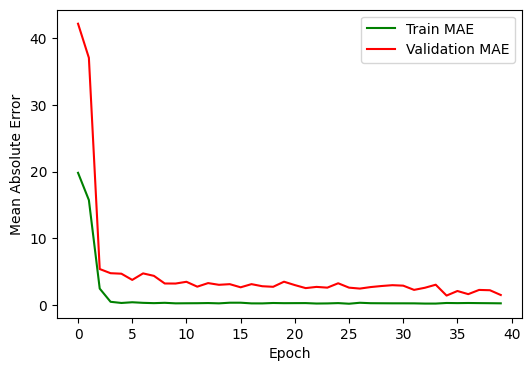

In [22]:
plot_history(LSTMhistory)

# Calculating the Mean Absolute Error

In [23]:
from sklearn.metrics import mean_absolute_error
# Making predictions using the trained model
y_train_LSTM = LSTMmodel.predict(X_train_dense)
y_val_LSTM = LSTMmodel.predict(X_val_dense)

# Calculating the mean absolute error from the training and validation sets
mae_train_LSTM = mean_absolute_error(r_train_dense, y_train_LSTM)
mae_val_LSTM = mean_absolute_error(r_val_dense, y_val_LSTM)

# Printing the mean absolute error from the training and validation sets
print("\"Current Network throuput\n train mae = ", mae_train_LSTM,
      "\n validation mae = ", mae_val_LSTM)

# Printing the shapes of the predicted output from the training and validation sets
print(y_train_LSTM.shape)
print(y_val_LSTM.shape)

23/23 [==============================] - 0s 5ms/step
"Current Network throuput
 train mae =  0.5078629 
 validation mae =  1.5104917
(3812, 1)
(735, 1)


# Ploting out predictions on the validation set



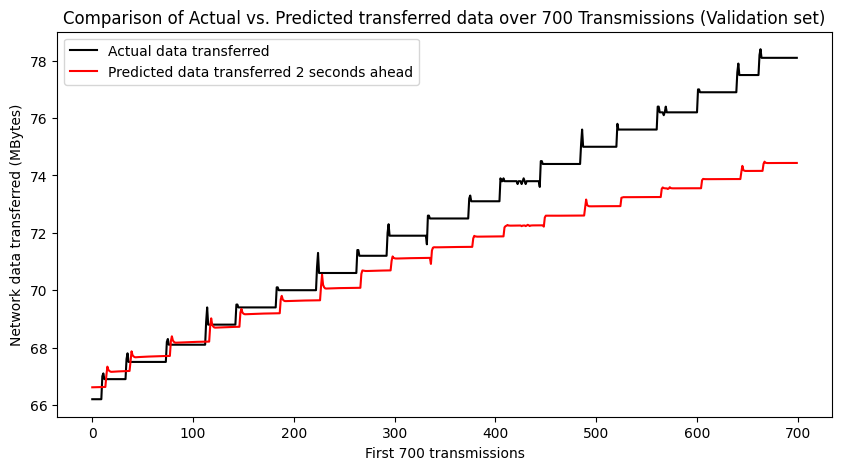

In [24]:
def scale_predictions_to_labels(labels, predictions):
    #scale_factor = np.mean(labels) / np.mean(predictions)
    scaled_predictions = predictions #* scale_factor
    return scaled_predictions

# Apply the scaling function
scaled_predictions = scale_predictions_to_labels(r_val_dense[:700], y_val_LSTM[:700, 0])

# Now plot the labels and predictions
plt.figure(figsize=(10, 5))
plt.plot(r_val_dense[:700], 'k-', label='Actual data transferred')
plt.plot(scaled_predictions[:700], 'r-', label='Predicted data transferred 2 seconds ahead')
plt.ylabel('Network data transferred (MBytes)')
plt.xlabel('First 700 transmissions')
plt.title('Comparison of Actual vs. Predicted transferred data over 700 Transmissions (Validation set)')  # Adding a title for context
plt.legend()
plt.show()


# Combining the training set and the validation set to create a larger training dataset.Trainining the model on this combined dataset to utilize all available data.Performing validation on the final test set to assess the model's performance on unseen data.



In [25]:
# Creating a windowed data_set
X_train_all_dense,r_train_all_dense = create_dataset_windowed(train_all_scaled,train_all_labels, window_size=100)
X_test_dense,r_test_dense = create_dataset_windowed(test_scaled,test_labels, window_size=100)

print(X_train_all_dense.shape)
print(r_train_all_dense.shape)
print(X_test_dense.shape)
print(r_test_dense.shape)

(4650, 100, 2)
(4650,)
(737, 100, 2)
(737,)


In [26]:
from tensorflow.keras.regularizers import L1L2
# Setting the number of units for the hidden layer in the RNN to 256
HIDDEN_RNN = 256
# regularisers - all set to zero for now
wreg = L1L2(l1=0, l2=0)

LSTM_model = Sequential()

# Adding layers to the model
LSTM_model.add(Dense(64, input_shape=(100,2), activation='relu'))
LSTM_model.add(LSTM(input_shape = (100,2),
                   units=HIDDEN_RNN,
                   return_sequences=False,
                   kernel_regularizer=wreg))

LSTM_model.add(Dense(32,activation='relu'))
LSTM_model.add(Dense(16,activation='relu'))
LSTM_model.add(Dense(8,activation='relu'))
LSTM_model.add(Dense(1))
LSTM_model.summary()

LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mae', metrics=['mae','mse'])

batch_size=32
epochs=40

# Training the model
LSTM_history = LSTM_model.fit(X_train_all_dense, r_train_all_dense,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_dense, r_test_dense),
          shuffle=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100, 64)           192       
                                                                 
 lstm_1 (LSTM)               (None, 256)               328704    
                                                                 
 dense_6 (Dense)             (None, 32)                8224      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 8)                 136       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 337793 (1.29 MB)
Trainable params: 33779

In [27]:
# Plotting the history of Mean Absolute Error for training_all_dataset and test sets
def plot_history_test(history):
  plt.figure(figsize = (6,4))

  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train_all MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Test MAE')
  plt.legend()
  plt.show()

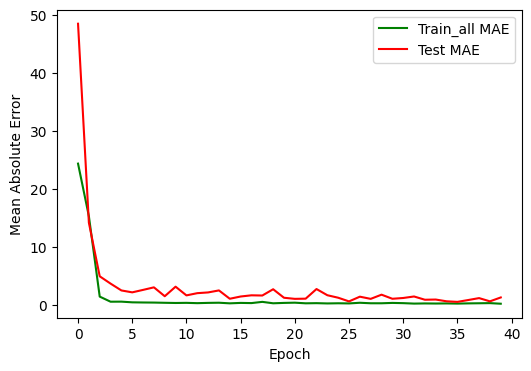

In [28]:
plot_history_test(LSTM_history)

# Calculating the average Mean Absolute Error on the test_set

In [29]:
from sklearn.metrics import mean_absolute_error
# Making predictions using the trained model
y_train_all_LSTM = LSTM_model.predict(X_train_all_dense)
y_test_LSTM = LSTM_model.predict(X_test_dense)

# Calculating the mean absolute error from the training_all_dataset and test sets
mae_train_all_LSTM = mean_absolute_error(r_train_all_dense, y_train_all_LSTM)
mae_test_LSTM = mean_absolute_error(r_test_dense, y_test_LSTM)

# Printing the mean absolute error from the training_all_dataeet and test sets
print("\"Current Network throuput\" baseline:\n train mae = ", mae_train_all_LSTM,
      "\n validation mae = ", mae_test_LSTM)

# Checking the shapes of the predicted output from the training_all_dataset and test sets
print(y_train_all_LSTM.shape)
print(y_test_LSTM.shape)

24/24 [==============================] - 0s 4ms/step
"Current Network throuput" baseline:
 train mae =  0.21320017 
 validation mae =  1.3223963
(4650, 1)
(737, 1)


# Visualizing the predictions on the test set

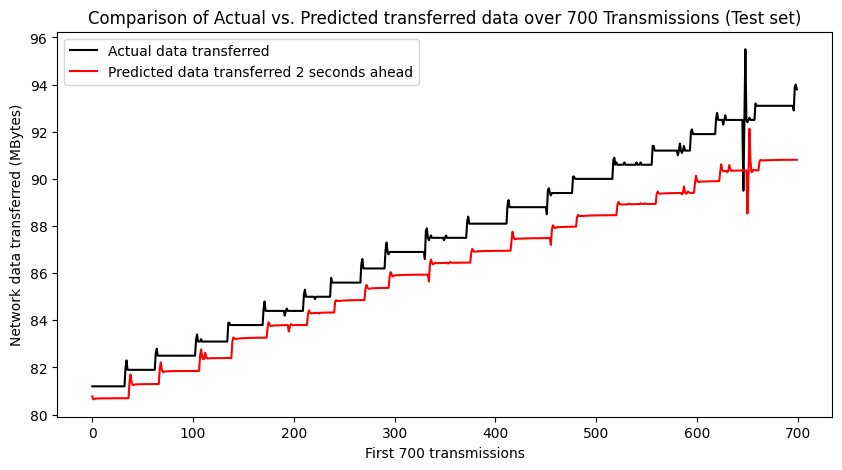

In [30]:
def scale_predictions_to_labels(labels, predictions):
    #scale_factor = np.mean(labels) / np.mean(predictions)
    scaled_predictions = predictions #* scale_factor
    return scaled_predictions

# Apply the scaling function
scaled_predictions = scale_predictions_to_labels(r_test_dense[:700], y_test_LSTM[:700, 0])

# Now plot the labels and scaled predictions
plt.figure(figsize=(10, 5))
plt.plot(r_test_dense[:700], 'k-', label='Actual data transferred')
plt.plot(scaled_predictions[:700], 'r-', label='Predicted data transferred 2 seconds ahead')
plt.ylabel('Network data transferred (MBytes)')
plt.xlabel('First 700 transmissions')
plt.title('Comparison of Actual vs. Predicted transferred data over 700 Transmissions (Test set)')
plt.legend()
plt.show()